In [0]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
%matplotlib inline
SPINE_COLOR = 'gray'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
# plt.rcParams['figure.dpi'] = 300

Read in our results from each version of the SAT solver from the CSV dumps

In [130]:
dataprefix = Path('sudokusat/results/data/resampled.csv/')
datapaths = [dataprefix/'09-28-16_26_45_results.csv',
             dataprefix/'09-28-16_57_25_results.csv',
             dataprefix/'09-28-21_20_57_results.csv',
            ]
print(datapaths)

[PosixPath('sudokusat/results/data/resampled.csv/09-28-16_26_45_results.csv'), PosixPath('sudokusat/results/data/resampled.csv/09-28-16_57_25_results.csv'), PosixPath('sudokusat/results/data/resampled.csv/09-28-21_20_57_results.csv')]


In [0]:
dfs = []
for datafile in datapaths:
    dfs.append(pd.read_csv(datafile))

In [132]:
for df in dfs: print(df.shape)

(2700, 10)
(2700, 10)
(2700, 10)


In [0]:
results = pd.concat(dfs)

In [134]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 0 to 2699
Data columns (total 10 columns):
Unnamed: 0         8100 non-null int64
backtracks         8100 non-null int64
calls              8100 non-null int64
conclusion         8100 non-null object
correct            8100 non-null bool
heuristic          8100 non-null object
puzzle             8100 non-null object
running_time       8100 non-null float64
simplifications    8100 non-null int64
splits             8100 non-null int64
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 640.7+ KB


In [0]:
results.drop('Unnamed: 0', axis='columns', inplace=True)

In [136]:
results.head()

,backtracks,calls,conclusion,correct,heuristic,puzzle,running_time,simplifications,splits
0,11,88,SAT,True,random_split,[[144]],3.443312,215,64
1,10,73,SAT,True,random_split,[[745]],2.754021,165,51
2,0,51,SAT,True,random_split,[[151]],2.958363,105,49
3,1,52,SAT,True,random_split,[[648]],3.167162,125,48
4,1,50,SAT,True,random_split,[[618]],2.659981,121,46


We now do a left join (on 'puzzle') of the original dataset onto the results. This allows us to have more information about the puzzle and the source dataset it originated from.


In [137]:
dataset = pd.read_csv('sudokusat/data/resampled.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 3 columns):
puzzle           2700 non-null object
source           2700 non-null object
starting_info    2700 non-null int64
dtypes: int64(1), object(2)
memory usage: 63.4+ KB


In [0]:
df = results.merge(dataset, how='left', on='puzzle')

In [139]:
df.head()

,backtracks,calls,conclusion,correct,heuristic,puzzle,running_time,simplifications,splits,source,starting_info
0,11,88,SAT,True,random_split,[[144]],3.443312,215,64,resampled,1
1,10,73,SAT,True,random_split,[[745]],2.754021,165,51,resampled,1
2,0,51,SAT,True,random_split,[[151]],2.958363,105,49,resampled,1
3,1,52,SAT,True,random_split,[[648]],3.167162,125,48,resampled,1
4,1,52,SAT,True,random_split,[[648]],3.167162,125,48,resampled,1


In [140]:
df.puzzle.unique().shape, df.puzzle.shape

((2688,), (8178,))

Now we can get a basic idea of the performance averages per heuristic.

In [141]:
df.groupby(['heuristic']).mean()

,backtracks,calls,correct,running_time,simplifications,splits,starting_info
heuristic,,,,,,,
jeroslow_wang_split,70.140499,219.982759,0.904989,2.092795,372.472487,79.298973,13.876742
moms_split,0.656640,43.960748,0.999266,3.085499,124.949376,40.654439,13.876742
random_split,5.939472,43.152971,0.996332,1.371528,118.124358,29.362436,13.876742


We'll also look at the fraction of tests that timed out for each heuristic.


In [142]:
df[df.conclusion == 'TIMEOUT']['heuristic'].value_counts(sort=True) / df.shape[0]

jeroslow_wang_split    0.031670
random_split           0.001223
moms_split             0.000245
Name: heuristic, dtype: float64

Jeroslow-Wang timed out way more often than the other heuristics. But for the rest of the data analysis, let's only consider puzzles for which all three heuristics did not time out (and were correct).


In [143]:
corrects = df.groupby('puzzle').mean()['correct'].reset_index()
print(corrects.shape)
corrects = corrects[corrects.correct == 1.0]
print(corrects.shape)
corrects = corrects.puzzle.values
len(corrects)

(2688, 2)
(2441, 2)


2441

In [144]:
df = df[df.puzzle.isin(corrects)].drop(['correct', 'conclusion'], axis='columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 0 to 8177
Data columns (total 9 columns):
backtracks         7368 non-null int64
calls              7368 non-null int64
heuristic          7368 non-null object
puzzle             7368 non-null object
running_time       7368 non-null float64
simplifications    7368 non-null int64
splits             7368 non-null int64
source             7368 non-null object
starting_info      7368 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 575.6+ KB


Next, let's look at some properties of the data.

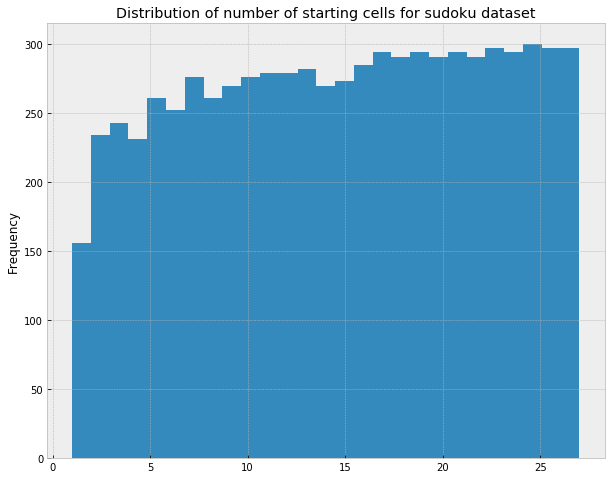

In [145]:
df['starting_info'].plot(kind='hist', title='Distribution of number of starting cells for sudoku dataset', bins=df.starting_info.unique().shape[0])

In [146]:
df.describe()

,backtracks,calls,running_time,simplifications,splits,starting_info
count,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000
mean,12.678339,63.023887,1.739274,143.811754,35.667210,14.680782
std,44.891571,133.985297,2.129538,218.688135,47.650292,7.610560
min,0.000000,2.000000,0.087649,13.000000,0.000000,1.000000
25%,0.000000,15.000000,0.401603,62.000000,11.000000,8.000000
50%,1.000000,28.000000,0.935288,90.000000,22.000000,15.000000
75%,4.000000,52.000000,2.068792,136.000000,42.000000,21.000000
max,400.000000,1210.000000,15.484811,2946.000000,413.000000,27.000000


Okay, now let's look at some trends.


In [147]:
df.corr()

,backtracks,calls,running_time,simplifications,splits,starting_info
backtracks,1.000000,0.986836,0.346261,0.967985,0.890621,-0.106829
calls,0.986836,1.000000,0.485614,0.985989,0.952441,-0.224379
running_time,0.346261,0.485614,1.000000,0.506242,0.713042,-0.664600
simplifications,0.967985,0.985989,0.506242,1.000000,0.948563,-0.233030
splits,0.890621,0.952441,0.713042,0.948563,1.000000,-0.429630
starting_info,-0.106829,-0.224379,-0.664600,-0.233030,-0.429630,1.000000


In [148]:
df.head()

,backtracks,calls,heuristic,puzzle,running_time,simplifications,splits,source,starting_info
0,11,88,random_split,[[144]],3.443312,215,64,resampled,1
1,10,73,random_split,[[745]],2.754021,165,51,resampled,1
6,0,52,random_split,[[155]],3.353546,119,50,resampled,1
8,4,70,random_split,[[199]],3.196045,140,60,resampled,1
9,4,70,random_split,[[199]],3.196045,140,60,resampled,1


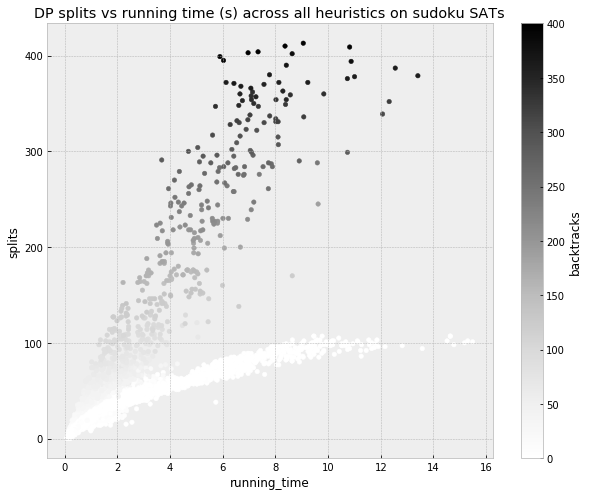

In [149]:
df[['running_time', 'calls', 'backtracks', 'splits', 'simplifications']].plot(kind='scatter', x='running_time', y='splits', c='backtracks', title='DP splits vs running time (s) across all heuristics on sudoku SATs')

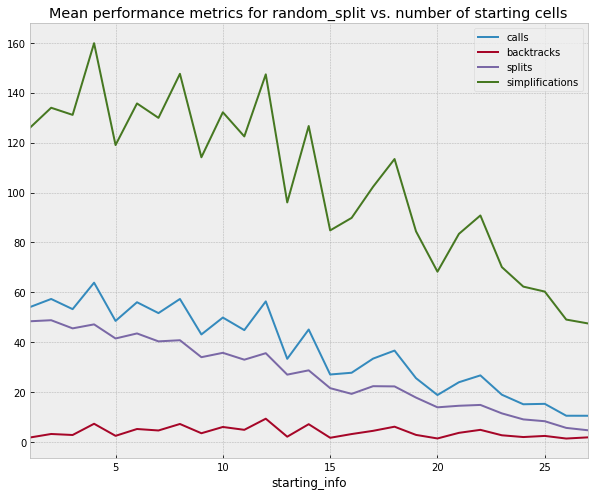

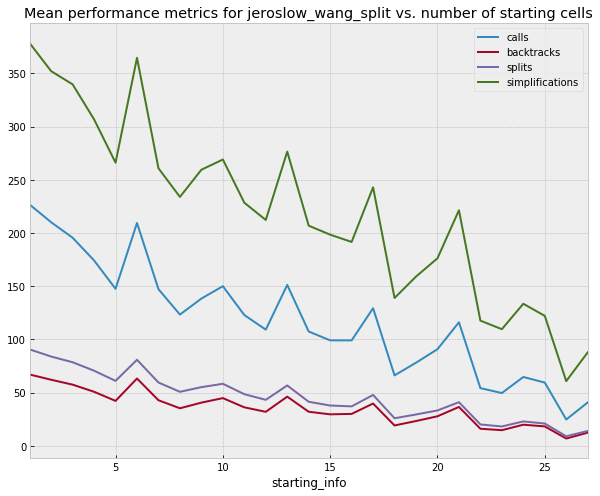

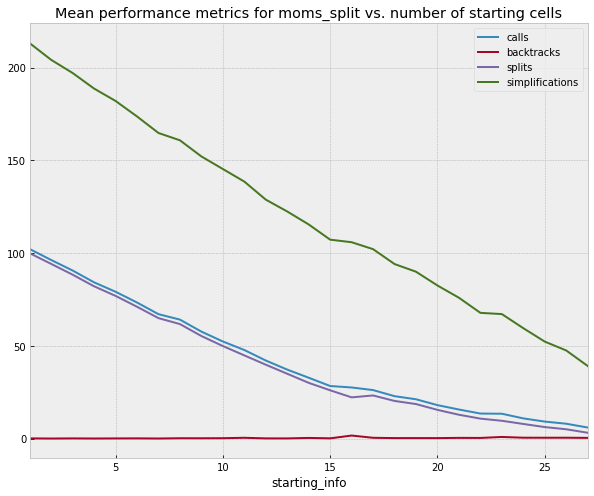

In [150]:
for heur in df.heuristic.unique():
    df[df.heuristic == heur].groupby('starting_info').mean()[['calls', 'backtracks', 'splits', 'simplifications']].plot(title=f'Mean performance metrics for {heur} vs. number of starting cells')

Those results are pretty surprising, so perhaps we need to contrast with the general SAT problems and see hwo they do.

In [151]:
dataprefix = Path('sudokusat/results/data/general.csv/')
datapaths = [dataprefix/'09-29-10_21_19_results.csv',
            dataprefix/'09-29-20_25_17_results.csv',
            dataprefix/'09-29-12_34_03_results.csv',
            ]

print(datapaths)

dfs = []
for datafile in datapaths:
    dfs.append(pd.read_csv(datafile))

for df in dfs: print(df.shape)

results2 = pd.concat(dfs).drop('Unnamed: 0', axis=1)


[PosixPath('sudokusat/results/data/general.csv/09-29-10_21_19_results.csv'), PosixPath('sudokusat/results/data/general.csv/09-29-20_25_17_results.csv'), PosixPath('sudokusat/results/data/general.csv/09-29-12_34_03_results.csv')]
(3199, 10)
(3199, 10)
(3199, 10)


In [152]:
results2.head()

,backtracks,calls,conclusion,correct,heuristic,problem,running_time,simplifications,splits
0,18,56,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,9.435179,159,18
1,17,53,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0376.cnf,8.642038,116,17
2,29,89,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0362.cnf,15.894175,244,29
3,33,101,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0404.cnf,17.482114,250,33
4,30,92,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0438.cnf,16.144455,216,30


In [153]:
dataset2 = pd.read_csv('sudokusat/data/general.csv')
dataset2.head()

,file,source
0,data/satlib/uniform/.DS_Store,satlib_uniform
1,data/satlib/uniform/UUF50.218.1000,satlib_uniform
2,data/satlib/uniform/uf50-218,satlib_uniform
3,data/satlib/uniform/UUF75.325.100,satlib_uniform
4,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,satlib_uniform


In [154]:
df2 = results2.merge(dataset2, how='left', left_on='problem', right_on='file')
df2.head()

,backtracks,calls,conclusion,correct,heuristic,problem,running_time,simplifications,splits,file,source
0,18,56,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,9.435179,159,18,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,satlib_uniform
1,17,53,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0376.cnf,8.642038,116,17,data/satlib/uniform/UUF50.218.1000/uuf50-0376.cnf,satlib_uniform
2,29,89,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0362.cnf,15.894175,244,29,data/satlib/uniform/UUF50.218.1000/uuf50-0362.cnf,satlib_uniform
3,33,101,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0404.cnf,17.482114,250,33,data/satlib/uniform/UUF50.218.1000/uuf50-0404.cnf,satlib_uniform
4,30,92,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0438.cnf,16.144455,216,30,data/satlib/uniform/UUF50.218.1000/uuf50-0438.cnf,satlib_uniform


In [155]:
df2.groupby('conclusion').mean()

,backtracks,calls,correct,running_time,simplifications,splits
conclusion,,,,,,
SAT,46.043440,235.649870,True,12.458270,549.635969,141.724587
TIMEOUT,1040.209050,3082.418099,False,30.053148,5799.413950,1040.209050
UNSAT,29.693058,91.079173,True,12.727836,212.015953,29.693058


In [156]:
df2.groupby('source').mean()

,backtracks,calls,correct,running_time,simplifications,splits
source,,,,,,
satlib_graph,366.404610,1089.616318,0.663027,23.729971,1776.012739,371.668790
satlib_uniform,668.249048,1997.966508,0.373016,20.838804,3943.750000,682.974921


In [157]:
df2.groupby('heuristic').mean()

,backtracks,calls,correct,running_time,simplifications,splits
heuristic,,,,,,
jeroslow_wang_split,704.87965,2101.004689,0.312285,19.713326,3201.237262,704.879650
moms_split,36.58362,139.804939,0.997187,17.215135,329.404189,64.901532
random_split,952.19256,2816.912785,0.108471,28.567687,6066.463582,958.300719


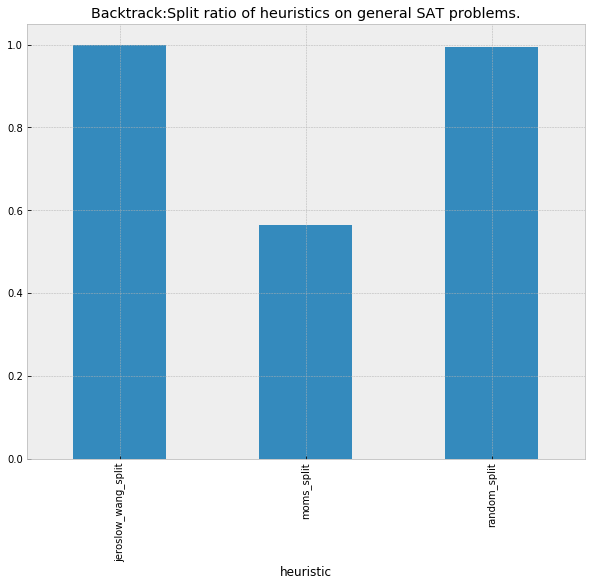

In [158]:
hperf = df2.groupby('heuristic').mean()
hperf['backtracks_per_split'] = hperf.backtracks / hperf.splits
hperf['backtracks_per_split'].plot(kind='bar', title='Backtrack:Split ratio of heuristics on general SAT problems.')

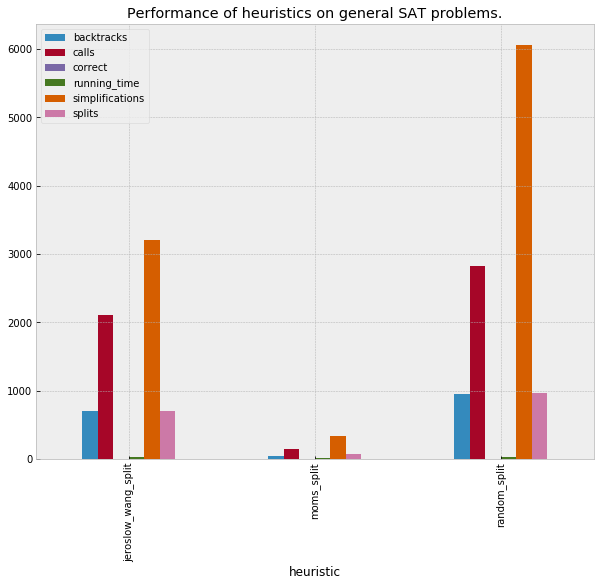

In [159]:
df2.groupby('heuristic').mean().plot(kind='bar', title='Performance of heuristics on general SAT problems.')